<a href="https://colab.research.google.com/github/hannaofficial/124M_GPT2_model_train_on_5B_tokens/blob/main/GPT3_124M_parameters_Model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

paper to read  https://arxiv.org/pdf/2205.14135.pdf


```
* Read gpt 2 gpt 3 paper finished
* flash attention
* fine web edu research paper
* Eleuther evaluation harness
* Fine tune for chatting (llama paper)
```
---



In [ ]:
"""
  GPT 3 used sparse attention(a sentence is not attented or dot product will all
  words in the sentences) this technique was used to reduce computational
  efficience from (N^2 to N.k). I used here full attention (N^2) because I was
  using 124m parameter i.e. small model size. and for now don't want to go in that complexity.
  Because my next project will be on building llama model from scrach there
  they use other attention mecchanism. I wanted to used that directly.

  All the rest of the model are same as GPT3 as state in there paper
"""

In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import inspect
import code

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")


print(f"using device: {device}")

using device: cuda


In [ ]:
import os

if you have more than one gpu you can work it together for fast training

```
 if more than one GPU available
 then use this command to run the code
 torchrun --standalone --nproc_per_node=2  /* here 2 means we have two gpu available*/ gpt2.py
```

In [ ]:
from torch.distributed import init_process_group, destroy_process_group

#set up DDP (distributed data parrallel)
#trochrun command set the env varable RANK, LOCALRANK and WORLD SIZE
ddp = int(os.environ.get('RANK',-1)) != -1
if ddp:
  assert torch.cuda.is_available(), 'for now i think we need cuda'
  init_process_group(backend='nccl')
  ddp_rank = int(os.environ['RANK'])  #identification of each gpu
  ddp_local_rank = int(os.environ['LOCAL_RANK'])  #rank of the gpu on single node
  ddp_world_size = int(os.environ['WORLD_SIZE'])  #total num of processes/gpu running
  device = f'cuda:{ddp_local_rank}'
  torch.cuda.set_device(device)
  master_process = ddp_rank == 0
else:
  #vanilla, non-DDP run
  ddp_rank = 0
  ddp_local_rank = 0
  ddp_world_size = 1
  master_process = True
  #attempt to autodetect device
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda"
  elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
  print(f"using device: {device}")

In [ ]:
device

In [ ]:
!nvidia-smi

In [ ]:
#Linear means y =  x*w**t + bias and nn.Linear(3,4)  in put dimension 3 output dimension 4

In [ ]:
#GPT MODEL CODE

In [ ]:
class NewGELU(nn.Module):
    """Careful there are a few versions of GeLU, this one is the exact one used by OpenAI"""
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))




class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

        #total parameter cal = [n_embed*3*n_embed + n_embed*n_embed(from proj)] in attenstion

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        # this materializes the large (T,T) matrix for all the queries and keys
        #att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        #att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        #att = F.softmax(att, dim=-1)
        #y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        #this is calling flash attention as torch compile directly cannot see the upper thing as one operation
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module): #multilayerperceptron that is feed forward network

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')      #NewGELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        """
        Here total parameter= n_embed*4*n_embed + 4*n_embed*n_embed
        """

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) #B T C
        x = x + self.mlp(self.ln_2(x))
        return x




@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

"""
  For each norm there are two parameter of each n_embed size:
  learned parameter and bias parameter there fore for each norm there are 2*n_embed parameter
  there are three normalization used here :
  3*2*n_embed = 6*n_embed  for layer normalization


  Parameter for embedding :
  vocab_size*n_embed

  there is no parameter for lm_head because it parameter is shared with embedding parameter

  for positional embedding parameter:
    block_size*n_embed
"""

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),  #block size is token size, n_embed is size of 1 tokens
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  #this can be change in fine tuning based on the labeled data based on GPT1



        #weight sharing (bottom token weight weight same as end weight ) from attention is all you need paper in that paper 30 dedicated to this research
        self.transformer.wte.weight = self.lm_head.weight

        #init parameters from gpt2 github code

        self.apply(self._init_weights)
    #this initiallisation is from gpt2 code
    def _init_weights(self, module):
      if isinstance(module, nn.Linear):
        std = 0.02
        if hasattr(module, 'NANOGPT_SCALE_INIT'): #we mul the  std by 1/sqr(N) because when standard deviation grows inside the residual and we can to keep it small so that when it grows it become normal value of std =0.02 as here
          std *= (2*self.config.n_layer)**-0.5  # 2x 12 layer we use this because std is adding in evdry residual path initially we are diving it with sqrt(2*12) so that after adding it becomes 0.02
          #here N is no of residual layer at each layer there are two residual layer that short circuiting of x and there are 12 layers
          #If you are really confused about what is residual layer search what is residual connection
          """
            This can be prove with simple basic concept let say X1 and X1 are random variable(rv) with std = 0.02 and var = std**2
            When they are sum ,variance are also added assumption each rv is independent
            Var(x) = Var(X1)+Var(X2) = 0.02**2 + 0.002**2 = 2*0.002^2  std  = sqrt(2)*0.02   that std is increase by factor sqrt(2) because only two random variable are there
            If we want to scale it down we have to divide it by sqrt(2)
            We want the final weight of residual connection should have std=0.02
          """
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
          torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
      B, T = idx.size()
      assert T <= self.config.block_size, f"Cannot forward of sequence of length {T}, block size is only {self.config.block_size}"

      pos = torch.arange(0,T, dtype=torch.long, device=idx.device)
      pos_emb = self.transformer.wpe(pos)
      tok_emb = self.transformer.wte(idx)
      x = tok_emb + pos_emb
      for block in self.transformer.h:
        x = block(x)
      x = self.transformer.ln_f(x)
      logits = self.lm_head(x)
      loss = None
      if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
      return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device):
      #start with all of the canditae parameters that requires grad
      param_dict = {pn: p for pn, p in self.named_parameters()}
      param_dict = {pn:p for pn,p in param_dict.items() if p.requires_grad}
      #create optim groups Any parameters that is 2D will be weught decayed otherwise no
      #i.e. all weight tensor in matmuls + embedding decay, all biases and layernorms don't
      decay_params = [p for n, p  in param_dict.items() if p.dim() >= 2]
      nodecay_params = [p for n,p  in param_dict.items() if p.dim() < 2]
      optim_groups = [
          {'params':decay_params, 'weight_decay': weight_decay},
          {'params': nodecay_params, 'weight_decay':0.0}
      ]
      num_decay_params = sum(p.numel() for p in decay_params)
      num_nodecay_params = sum(p.numel() for p in nodecay_params)
      print(f"num decayed parameter tensor: {len(decay_params)}, with {num_decay_params:,} parameter")
      print(f"nu,m non-deacyed parameter tenor: {len(nodecay_params)}, with {num_nodecay_params:,} parameter")
      # create adam optimiser and use the fused version if it is available
      fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters  #to see whether fused option is present or not in pytorch
      print(f"fused_available: {fused_available} and device is cuda: { device == 'cuda'} ")
      use_fused = fused_available and  device == 'cuda' #if gpu then use cuda
      print(f"using fused AdamW: {use_fused}")
      optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
      return optimizer








In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt




In [ ]:
!pip install tiktoken datasets tqdm

In [ ]:
import os
import multiprocessing as mp
import numpy as np
import tiktoken
from datasets import load_dataset
from tqdm import tqdm

local_dir = "filter_fineweb5B"
shard_size = int(1e8)


DATA_CACHE_DIR = os.path.join(os.getcwd(), local_dir)
os.makedirs(DATA_CACHE_DIR , exist_ok=True)

#download the dataset

#fw = load_dataset("HuggingFaceFW/fineweb-edu", name=remote_name, split="train")
# Define the specific parquet files you want to load (first seven)
data_files = [f"sample/10BT/{i:03d}_00000.parquet" for i in range(2)]

# Load only these specific files from the dataset
fw = load_dataset(
    "HuggingFaceFW/fineweb-edu",
    data_files=data_files,
    split="train"
)

In [ ]:
!rm -rf /content/filter_fineweb5B

In [ ]:
def tokenize(doc):
  enc = tiktoken.get_encoding("gpt2")
  eot = enc._special_tokens["<|endoftext|>"]
  tokens = [eot]
  tokens += enc.encode(doc["text"], allowed_special={"<|endoftext|>"})
  tokens_np = np.array(tokens, dtype=np.uint16)
  #ensures that all token values are within the valid range for uint16.
  assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "greater than 2**16 ie that is file is too big"
  return tokens_np

def write_datafile_in_byte(file_name, tokens_np):
  np.save(file_name, tokens_np)
  # with open(file_name, "wb") as file:
  #   file.write(tokens_np.tobytes())  in these way we are saving the file as .bin format that is byte not npy


In [ ]:
nprocessors = max(1, int(os.cpu_count()/2) )
print(f"using {nprocessors} processes")

In [ ]:
#there are some changes here handing some new cases other than the karpathy code

In [ ]:
with mp.Pool(nprocessors) as pool:
  shard_index = 0
  all_tokens_np = np.empty((shard_size,), dtype=np.uint16)
  token_count = 0
  progress_bar = None
  for tokens in pool.imap(tokenize, fw, chunksize=8):
    if token_count + len(tokens) < shard_size:
      all_tokens_np[token_count:token_count+len(tokens)] = tokens
      token_count += len(tokens)
      if not progress_bar:
        progress_bar = tqdm(total=shard_size, unit="token", desc=f"writing shard {shard_index}")
      progress_bar.update(len(tokens))
    else:
      split = "val" if shard_index == 0 else "train"
      file_name = os.path.join(DATA_CACHE_DIR, f"partialfineweb_{split}_{shard_index:04d}.npy")
      remaining_token = shard_size - token_count
      progress_bar.update(remaining_token)
      all_tokens_np[token_count:token_count+remaining_token] = tokens[:remaining_token]
      write_datafile_in_byte(file_name, all_tokens_np)
      shard_index += 1
      progress_bar.close()
      progress_bar = None

      remaining_tokens = tokens[remaining_token:]

      while len(remaining_tokens) > shard_size:
          split = "val" if shard_index == 0 else "train"
          file_name = os.path.join(DATA_CACHE_DIR, f"partialfineweb{split}_{shard_index:04d}.npy")
          progress_bar = tqdm(total=shard_size, unit="token", desc=f"writing shard {shard_index}")
          all_tokens_np[0:shard_size] = remaining_tokens[:shard_size]
          write_datafile_in_byte(file_name, all_tokens_np)
          progress_bar.update(shard_size)
          progress_bar.close()
          shard_index += 1
          remaining_tokens = remaining_tokens[shard_size:]

      all_tokens_np[0:len(remaining_tokens)] = remaining_tokens
      token_count = len(remaining_tokens)


  if token_count > 0:
    split = "val" if shard_index == 0 else "train"
    file_name = os.path.join(DATA_CACHE_DIR, f"partialfineweb{split}_{shard_index:04d}.npy")
    write_datafile_in_byte(file_name, all_tokens_np)
    if progress_bar:
      progress_bar.close()


In [ ]:
!apt-get install -y p7zip-full

```
!7z x compressed_file.7z  #for uncompressing
```

In [ ]:
!7z a -t7z -mx=8 /content/filter_fineweb5B.7z /content/filter_fineweb5B

In [ ]:
from google.colab import files
files.download('/content/filter_fineweb5B.7z')

In [ ]:
!zip -r /content/filter_fineweb5B.zip /content/filter_fineweb5B


In [ ]:
num_return_sequences = 5
max_length = 30


In [ ]:
!pip install tiktoken

```
Here's a breakdown of the issue:

You are using torch.compile to optimize your model, and PyTorch Inductor is selected as the backend.
Inductor requires the Triton library to generate efficient kernels for your model's operations.
However, either Triton is not installed in your environment or the installed version is not compatible with Inductor.
```

In [ ]:
!pip install triton  #this is used for torch.compile


In [ ]:
import tiktoken
import time
import triton
import numpy as np

In [ ]:
def load_tokens(file_name):
        npt = np.load(file_name)
        return torch.tensor(npt, dtype=torch.long)

In [ ]:
import tiktoken

class DataLoaderLite:
  def __init__(self, B, T, process_rank, num_processes, split):
    self.B = B
    self.T = T
    self.process_rank = process_rank
    self.num_processes = num_processes
    assert split in {'train', 'val'}

    #getting the shard filenames
    data_root = "filter_fineweb5B"
    shards = os.listdir(data_root)
    shards = [s for s in shards if split in s]
    shards = sorted(shards)
    shards = [os.path.join(data_root, s) for s in shards]
    self.shards = shards
    assert len(shards) > 0, f"no shards found for {split} split"
    if master_process:
      print(f"found {len(shards)} shards for split {split}")

    self.reset()

  def reset(self):
      self.current_shard = 0
      self.tokens = load_tokens(self.shards[self.current_shard])
      self.current_position = self.B*self.T*self.process_rank


    # with open('input.txt','r') as f:
    #   text = f.read()
    # enc = tiktoken.get_encoding('gpt2')
    # tokens = enc.encode(text)
    # self.tokens = torch.tensor(tokens)
    # print(f"loaded {len(self.tokens)} tokens")
    # print(f"1 epoch = {len(self.tokens) // (B*T*self.num_processes)} batches")

    # self.current_shard = 0
    # self.tokens = load_tokens(self.shards[self.current_shard])
    # self.current_position = self.B*self.T*self.process_rank  #for eg process rank one with start at 0 as rank == 0 number of rank means number of gpu used together

  def next_batch(self):
    B, T = self.B, self.T
    buf = self.tokens[self.current_position: self.current_position+ B*T + 1]
    x = (buf[:-1]).view(B, T)
    y = (buf[1:]).view(B, T)
    self.current_position += B*T*self.num_processes
    if self.current_position + (B*T*self.num_processes + 1) > len(self.tokens):
      self.current_shard = (self.current_shard + 1) % len(self.shards)
      self.tokens = load_tokens(self.shards[self.current_shard])
      self.current_position = B*T*self.process_rank
    return x, y

In [ ]:
total_batch_size = 524288  #2**19, ~0.5M taken from gpt3 paper
B=16
T = 1024
assert total_batch_size%(B*T*ddp_world_size) == 0, "make sure total_batch size divides B*T"
grad_accum_steps = total_batch_size // (B*T*ddp_world_size)  #ddp_world_size tell what is the total  number of gpu avaiable we have one one now hahaha
#if below logic is not provided for each gpu it will print each time master process is the main gpu we assign
if master_process:
  print(f"total desired batch size: {total_batch_size}")
  print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

In [ ]:
# Check one file's format
file_path = 'filter_fineweb5B/partialfineweb_train_0001.npy'

# Print first few bytes
with open(file_path, 'rb') as f:
    print("First few bytes:", [hex(b) for b in f.read(8)])

# Print file size
print("File size:", os.path.getsize(file_path))

# Try direct numpy load
try:
    data = np.load(file_path, allow_pickle=True)
    print("Successfully loaded with shape:", data.shape)
    print("Data type:", data.dtype)
except Exception as e:
    print("Load error:", str(e))

In [ ]:
#hellaswag file download
import os
import json
import requests
import tiktoken
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel

# -----------------------------------------------------------------------------
#os.getcwd() to get the current working dir
DATA_CACHE_DIR = os.path.join(os.getcwd(), "hellaswag")

def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

hellaswags = {
    "train": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_train.jsonl",
    "val": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_val.jsonl",
    "test": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_test.jsonl",
}

enc = tiktoken.get_encoding("gpt2")
def download(split):
    """Downloads HellaSwag DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)
    data_url = hellaswags[split]
    data_filename = os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)



In [ ]:
def render_example(example):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = enc.encode(ctx)
    data["ctx_tokens"] = ctx_tokens
    tok_rows = []
    mask_rows = []
    #ending are options 4 option ctx are the intial sentences
    for end in endings:
        end_tokens = enc.encode(" " + end) # note: prepending " " because GPT-2 tokenizer
        tok_rows.append(ctx_tokens + end_tokens)
        mask_rows.append([0]*len(ctx_tokens) + [1]*len(end_tokens))
        data["ending_tokens"].append(end_tokens)

    # have to be careful during the collation because the number of tokens in each row can differ
    max_len = max(len(row) for row in tok_rows)
    tokens = torch.zeros((4, max_len), dtype=torch.long)
    mask = torch.zeros((4, max_len), dtype=torch.long)
    #this line of code : let's say 10 is max length and if one token length is 8 then it will add two zeros to compensate with the length it has done both for token and mask_row
    for i, (tok_row, mask_row) in enumerate(zip(tok_rows, mask_rows)):
        tokens[i, :len(tok_row)] = torch.tensor(tok_row)
        mask[i, :len(mask_row)] = torch.tensor(mask_row)

    return data, tokens, mask, label
    """
      tokens are the example [ctx + e1, ctx +e2, ctx+e3, ctx+e4] that means there are four option
      mask tells which one are options by labelling each option with 1 and ctx as 0
    """


def iterate_examples(split):
    # there are 10,042 examples in total in val
    download(split)
    with open(os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl"), "r") as f:
        for line in f:
            example = json.loads(line)
            yield example

def get_most_likely_row(tokens, mask, logits):

    B, T = tokens.size()
    # shift the tokens and mask to the left by one position
    shift_tokens = tokens[..., 1:].contiguous()  #remove the starting token
    #shift_mask = mask[..., 1:].contiguous()
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    #shift_tokens = (tokens[..., 1:,(error here) :]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1)) #1
    flat_shift_tokens = shift_tokens.view(-1) #1
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask #2
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

    """
     Let me translate this code in my language:
      we take logit before last token because there is no word to match for the prediction of the last words in token.
      Now in each row in logit contains the next predicted word
      And we need to calculate cross_entropy for each token
      there for we need second token from tokens list. (This is simple just think)
      now we spreading all the token and calculating the cross entropy loss #1(indicated explanation of #1 code)
      Now reshape the losses in (tokens.size(0), -1)  so that we can get the losses for each row in the token
      We are shifting the mask because 1 in mask include just the ending part of the sentence but we want to add
         the last token of the ctx because that token in logit will have the information for the next token
      #2 Now when we * losses with mask we will get losses of just the ending not the ctx
      Then we are getting the average loss of each token
      We will take the id with the less average loss that is the most likely token
    """

In [ ]:
train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='train')   #in original gpt it is 16 but I put 8 because of computer efficiency
val_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split='val')
#if you have not gpu or high efficient gpu you can take high batch intead we do gradient accumulation technique to do the same because batch size it directly corelated to
#other paramaters
torch.set_float32_matmul_precision('high')
 #by default it at highest using float32 now it will use tensor 32 as it will cut down some precision but not much
#it cut cut down just the mantissa {1.23234 * 10^2} 1.23234 is mantissa and base and exponential

```
import code: code.interact(local=locals())
 ```
 this is important when we need to stop code in middle and check the variable or anything you want with the above code

In [ ]:
import torch
# import torch_xla
# import torch_xla.core.xla_model as xm   for tpu we need this
import time
import torch.distributed as dist


torch.manual_seed(1337)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1337)



# I add this to suppress some error I have to look into these afterwards
import torch._dynamo
torch._dynamo.config.suppress_errors = False
torch._dynamo.config.automatic_dynamic_shapes = True

# Get TPU device
# device = xm.xla_device()  initially I was using free TPU that's why I was using this code

# Initialize model and move it to TPU
model = GPT(GPTConfig(vocab_size=50304))  # 50304 is nice number many times divisible by two if number is not good then we should at first increase the num not decrease and see nearest number that can be used that is divisible by many time by two
#because we know computer understand binary number that why it can really compute first if the number is in 2 to the power even it gpu at first it do all the calculation that has 2 power then after than that it will handle all the other number
model = model.to(device)


model = torch.compile(
    model
)
if ddp:
  model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[ddp_local_rank])

raw_model = model.module if ddp else model

max_lr = 6e-4
min_lr = max_lr*0.1
warmup_steps = 286 #as gpt 3 10B parameter they take 3% of token in warmup step our 5B parameter 3% is 150 million 150m /2**19~286
max_steps = 9536 #this is just got by we have 5B tokens it each step we process 2**19 tokens total number of step in 1 epoch


#learning rate based on step intially it will increase unit the max_learning rate then it will decrease based on cosine
def get_lr(it):
  if it < warmup_steps:
    return max_lr*(it+1)/ warmup_steps
  if it > max_steps:
    return min_lr
  decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
  assert 0 <= decay_ratio <= 1
  coeff = 0.5 * (1.0 + math.cos(math.pi*decay_ratio))
  return min_lr + coeff*(max_lr - min_lr)




#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), eps=1e-8, weight_decay=0.1, fused=False) #we are using false it showing some error in tensor only available for cuda

#accumulation_steps = 2  # Accumulate gradients over 2 steps

#log directory to write helloswag and loss value
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: #open for writing for clearing the file
  pass
rang = 10000
for step in range(rang):
    t0 = time.time()
    last_step = (step == (rang - 1))

    # doing validation after 100 steps
    if step % 50 == 0:
      model.eval()
      val_loader.reset()
      with torch.no_grad():
        val_loss_accum = 0
        val_loss_steps = 20
        for _ in range(val_loss_steps):
          x, y = val_loader.next_batch()
          x, y = x.to(device), y.to(device)
          with torch.autocast(device_type=device, dtype=torch.float16): #bfloat16 --> float16 due to gpu compute capacity less than 8
            logits, loss = model(x, y)
          loss = loss/val_loss_steps
          val_loss_accum += loss.detach()
      if ddp:
        dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
      if master_process:
        print(f"validation loss: {val_loss_accum.item():.4f}")
        #saving the value of validation in log.txt
        with open(log_file, "a") as f:
                f.write(f"{step} val {val_loss_accum.item():.4f}\n")
        if step > 0 and (step % 5000 == 0 or last_step):
                # this is code for intermediate saving of model
                checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'val_loss': val_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)


    #helloswag eval
    if (step % 50 == 0 or last_step):
      num_correct_norm = 0
      num_total = 0
      for i, example in enumerate(iterate_examples("val")):
        if i% ddp_world_size != ddp_rank:
          continue
        _, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)
        #get the logits
        with torch.no_grad():
          with torch.autocast(device_type=device, dtype=torch.float16):
            logits, _ = model(tokens)
          pred_norm = get_most_likely_row(tokens, mask, logits)
        num_total += 1
        num_correct_norm += int(pred_norm == label)

      if ddp:
        num_total = torch.tensor(num_total, dtype=torch.long, device=device)
        num_correct_norm = torch.tensor(num_correct_norm, dtype=torch.long, device=device)
        dist.all_reduce(num_correct_norm, op=dist.ReduceOp.SUM)
        dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
        num_total = num_total.item()
        num_correct_norm = num_correct_norm.item()
      acc_norm = num_correct_norm/num_total
      if master_process:
        print(f"helloswag accuracy: {num_correct_norm}/{num_total} {acc_norm:.4f}")
        #saving value of hella in log.txt
        with open(log_file, "a") as f:
                f.write(f"{step} hella {acc_norm:.4f}\n")

    #generating text
    if step > 0 and step % 5 == 0:
      model.eval()
      num_return_sequences = 4
      max_length = 32
      enc = tiktoken.get_encoding("gpt2")
      tokens = enc.encode("Hello, I'm a language model,")
      tokens = torch.tensor(tokens, dtype=torch.long)
      tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)  #adding dimension to tokens -->(1,T) and then --> (num_return, T)
      tokens = tokens.to(device)
      sample_rng = torch.Generator(device=device)
      sample_rng.manual_seed(42 + ddp_rank)
      while tokens.size(1) < max_length:
        with torch.no_grad():
          logits, loss = model(tokens)  #(B, T, vocab_size)
          #take the logits at the last position
          logits = logits[:, -1, :]  #(B, vocab_size)
          #get the probabilities
          probs = F.softmax(logits, dim=-1)
          topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
          ix = torch.multinomial(topk_probs, num_samples=1, replacement=True, generator=sample_rng)
          xcol = torch.gather(topk_indices, dim=-1, index=ix)
          tokens = torch.cat((tokens, xcol), dim=1)
          """
           We are getting the probs of the next token
           then we selecting the top 50 possible probs with their index that reduce the chance of predicting unlikely token
           we chose the token , the token with higher prob has high likely to select we get id of that token
           .gather function helps to get the original index from vocabulary using ix got from .multinomial function
           that id is store in xcol and finally added to tokens
          """
      print(f"tokens: {tokens}")
      for i in range(num_return_sequences):
        tokens_list = tokens.tolist()
        tokens_to_decode = tokens_list[i][:max_length]
        #tokens = tokens[i, :max_length].tolist()  there is showing some error
        decoded = enc.decode(tokens_to_decode)
        print(f"rank {ddp_rank} sample {i}: {decoded}")





    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    #grad acumulation step is done here we are just adding the gradient unit it match the token size of gpt3
    for micro_step in range(grad_accum_steps):
      x, y = train_loader.next_batch()
      x, y = x.to(device), y.to(device)
      with torch.autocast(device_type=device, dtype=torch.float16): #if tpu then xla instead of device -----my model don't support bfloat as it has compute capacity less than 7.5 that's why change it to float16
          logits, loss = model(x, y)  #this is use to convert tensor 32 to bfloat16 but only for logits not other weight varible therefore it is called mixed precision
      loss = loss / grad_accum_steps  # Scale loss to account for accumulation  because here we are accumualting the loss , in B*T loss is calculated by sum of all the loss divide by num of loss accumulation done i.e reduction is by mean
      loss_accum += loss.detach()  #detaching the tensor so that i can keep track of the value just
      if ddp:
        model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)  #we don't want to sync all the time that is wastage of gpu we only sync all the loss at the last time
      loss.backward()

    if ddp:
      dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)   #this loss accum is available is all the rank and it average all the loss_accum and average it


    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # this is actally root mean square of all the gradient if prevents the model to deal with bad batch data that might lead to spike in the grad
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
      param_group['lr'] = lr

    optimizer.step()

    torch.cuda.synchronize() #wait for the gpu to finish the work
    t1 = time.time()
    tokens_processed = train_loader.B*train_loader.T*grad_accum_steps
    tokens_per_sec = tokens_processed/(t1-t0)
    if master_process:
        print(f"step {step} | loss: {loss_accum.item()} | lr: {lr:.4e} | norm: {norm:.4f} | dt={(t1-t0)*1000:.2f}ms | {tokens_per_sec:.2f} tokens/sec")
        #saving value of loss function
        with open(log_file, "a") as f:
            f.write(f"{step} train {loss_accum.item():.6f}\n")


if ddp:
  dist.destroy_process_group()  #it will dislink the connected gpu



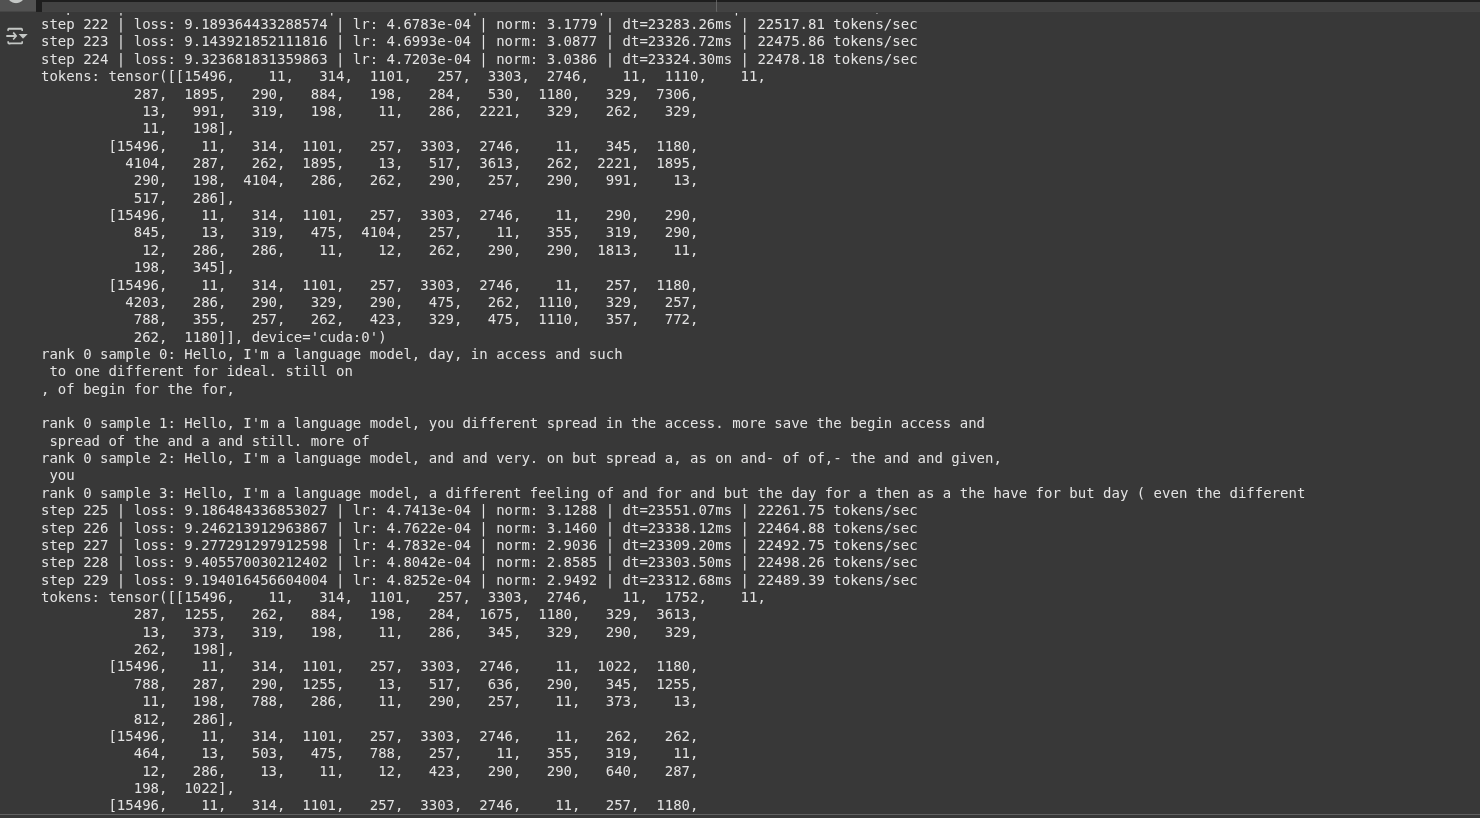